In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import xgboost as xgb

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/marek/.cache/kagglehub/datasets/lakshmi25npathi/bike-sharing-dataset/versions/1


In [3]:
dataset_path = "/Users/marek/.cache/kagglehub/datasets/lakshmi25npathi/bike-sharing-dataset/versions/1"

files = os.listdir(dataset_path)
print(files)


['hour.csv', 'Readme.txt', 'day.csv']


In [4]:
file_path = "/Users/marek/.cache/kagglehub/datasets/lakshmi25npathi/bike-sharing-dataset/versions/1/hour.csv"

df = pd.read_csv(file_path)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The hand-in exercise for this topic is Task 3,4 and 6 from the notebook “TSA_Task”. This
means that you have to do the cleaning of dataset, then create features (at least 5 new
features should be created, and you should be able to justify why you created each of the
features). And then, you should train an XGBoost model on the dataset. Note that you also
need to do relevant train, test, validation split and be able to explain why you chose a
certain split. Lastly, you should calculate evaluation metrics: rmse and mae to show
performance of your model. The hyperparameter tuning part is not required.

## **Exercise**

1. Load the [dataset](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) from Kaggle. Use the "hour.csv" file.
2. Visualize the structure of the dataset using appropriate libraries and plots.
3. Clean and pre-process the dataset as required and prepare the data for modelling.
4. Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling mean, last 3 hours rolling mean, etc. But it should be based on your dataset and what makes sense for this dataset.
5. Implement linear regression to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.
6. Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.
7. Experiment with predicting different time periods, such as use all data to predict bike rentals for just the next day (24 hours) or the next entire month and then see how much better or worse the model gets
8. Experiment tuning hyperparameters

In [5]:
df['datetime'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00')
df = df.set_index('datetime')
df = df.sort_index()
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


4. Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling mean, last 3 hours rolling mean, etc. But it should be based on your dataset and what makes sense for this dataset.

In [6]:
def create_features(df):

    df = df.copy()

    df['lag_1d'] = df['cnt'].shift(24)
    df['lag_1w'] = df['cnt'].shift((24*7))
    df['lag_1m'] = df['cnt'].shift((24*7*4))
    df['lag_3m'] = df['cnt'].shift((24*7*4*3))
    df['lag_6m'] = df['cnt'].shift((24*7*4*6))
    df['lag_1y'] = df['cnt'].shift((365*24))

    df['rolling_mean_3d'] = df['cnt'].rolling(window=24*3).mean()
    df['rolling_mean_1w'] = df['cnt'].rolling(window=24*7).mean()
    df['rolling_mean_1m'] = df['cnt'].rolling(window=24*7*4).mean()
    df['rolling_mean_3m'] = df['cnt'].rolling(window=24*7*4*3).mean()
    df['rolling_mean_6m'] = df['cnt'].rolling(window=24*7*4*6).mean()
    df['rolling_mean_1y'] = df['cnt'].rolling(window=24*365).mean()

    return df

df_features = create_features(df)

df_features.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,lag_1m,lag_3m,lag_6m,lag_1y,rolling_mean_3d,rolling_mean_1w,rolling_mean_1m,rolling_mean_3m,rolling_mean_6m,rolling_mean_1y
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5. Implement linear regression to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

<Figure size 640x480 with 0 Axes>

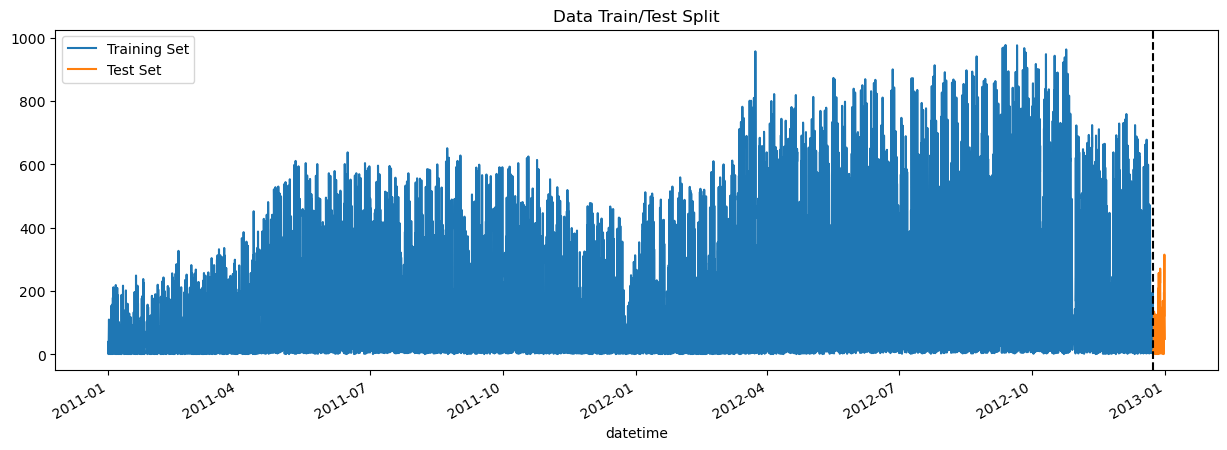

In [7]:
train = df.loc[df.index < '12-24-2012']
test = df.loc[df.index >= '12-24-2012']

sns.reset_defaults()
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train['cnt'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['cnt'].plot(ax=ax, label='Test Set')
ax.axvline('12-24-2012', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [8]:

X_train_lr = train[['season','yr','mnth','hr','weathersit','windspeed']]
y_train_lr = train[['cnt']]

X_test_lr = test[['season','yr','mnth','hr','weathersit','windspeed']]
y_test_lr = test[['cnt']]


lr = sm.OLS(y_train_lr, X_train_lr).fit()

lr.summary()

y_pred_lr = lr.predict(X_test_lr)


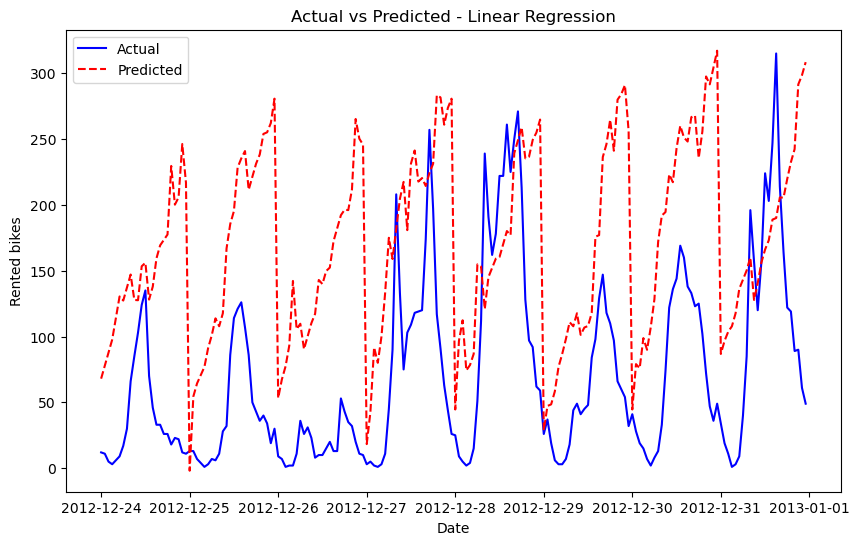

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_lr.index, y_test_lr, label='Actual', color='blue')
plt.plot(y_test_lr.index, y_pred_lr, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Rented bikes')
plt.legend()
plt.show()

6. Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

In [10]:
xgb_train = create_features(train)
xgb_test = create_features(test)

X_train_xgb = xgb_train[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_train_xgb = xgb_train['cnt']

X_test_xgb = xgb_test[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_test_xgb = xgb_test['cnt']


In [11]:

dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

y_pred_xgb = reg.predict(dtest)


[0]	train-rmse:180.49412	eval-rmse:137.79577
[100]	train-rmse:106.42315	eval-rmse:77.13087


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:86.83975	eval-rmse:60.57834
[300]	train-rmse:81.24168	eval-rmse:56.72853
[400]	train-rmse:78.79117	eval-rmse:55.84872
[500]	train-rmse:77.33627	eval-rmse:55.75064
[584]	train-rmse:76.40697	eval-rmse:55.83124


/var/folders/yq/94jp9phd29s5g98ng2hwj0000000gn/T/ipykernel_91890/3304219864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(dtest)


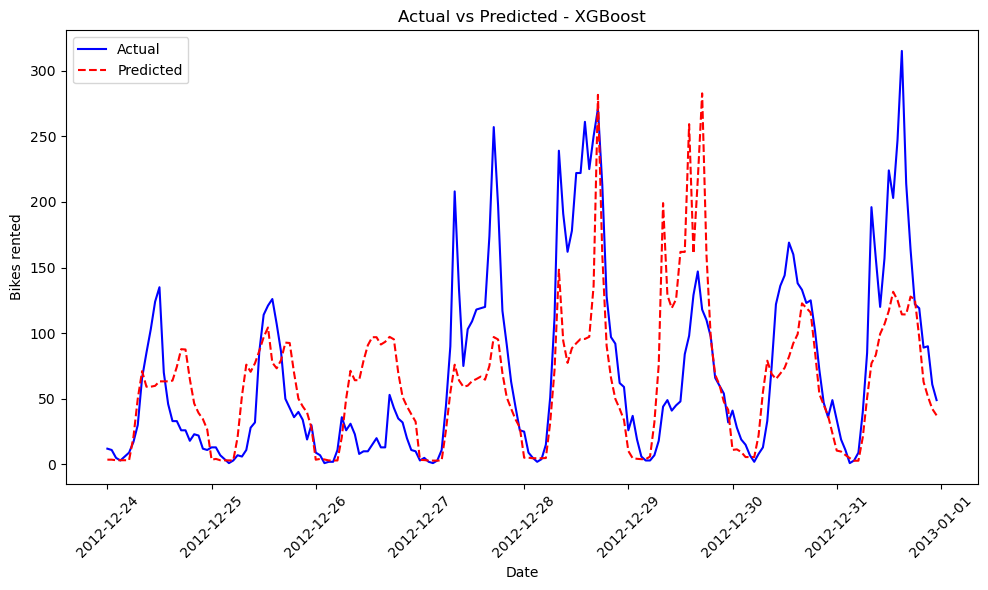

In [12]:

if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


plt.figure(figsize=(10, 6))
plt.plot(y_test_xgb.index, y_test_xgb, label='Actual', color='blue')
plt.plot(y_test_xgb.index, y_pred_xgb, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - XGBoost')
plt.xlabel('Date')
plt.ylabel('Bikes rented')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

7. Experiment with predicting different time periods, such as use all data to predict bike rentals for just the next day (24 hours) or the next entire month and then see how much better or worse the model gets

[0]	train-rmse:180.71393	eval-rmse:165.50648


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:106.47449	eval-rmse:109.38094
[200]	train-rmse:86.75378	eval-rmse:98.51254
[300]	train-rmse:81.18032	eval-rmse:95.24587
[400]	train-rmse:78.77209	eval-rmse:93.32523
[500]	train-rmse:77.30629	eval-rmse:92.43949
[600]	train-rmse:76.14326	eval-rmse:91.81659
[700]	train-rmse:75.20906	eval-rmse:91.65422
[800]	train-rmse:74.33747	eval-rmse:91.14669
[900]	train-rmse:73.53216	eval-rmse:90.45227
[999]	train-rmse:72.71921	eval-rmse:89.79388


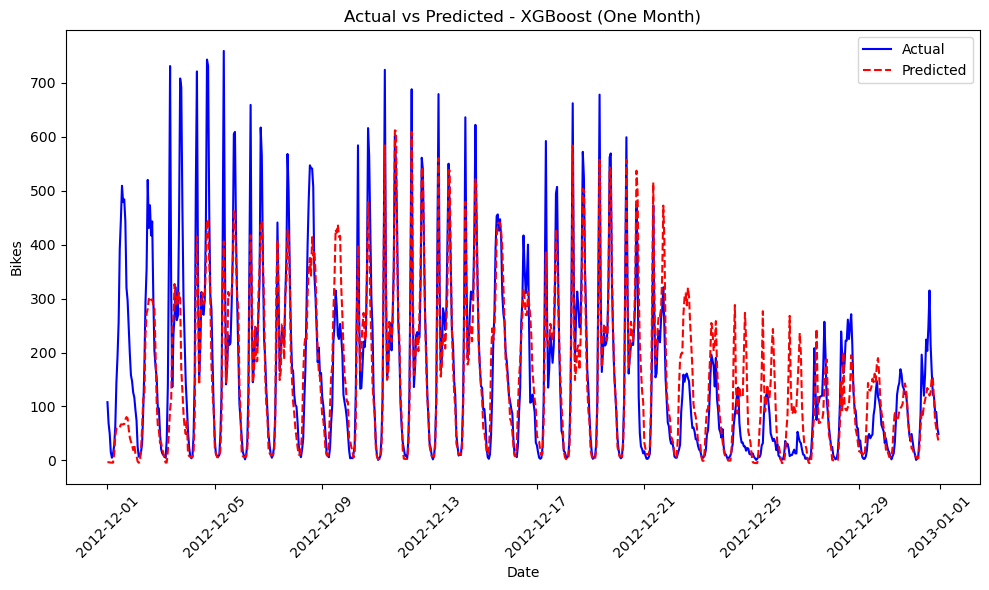

In [13]:
train = df.loc[df.index < '12-1-2012']
test = df.loc[df.index >= '12-1-2012']

xgb_train = create_features(train)
xgb_test = create_features(test)

X_train_xgb = xgb_train[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_train_xgb = xgb_train['cnt']

X_test_xgb = xgb_test[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_test_xgb = xgb_test['cnt']

import xgboost as xgb

dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

y_pred_xgb = reg.predict(dtest)



if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


plt.figure(figsize=(10, 6))
plt.plot(y_test_xgb.index, y_test_xgb, label='Actual', color='blue')
plt.plot(y_test_xgb.index, y_pred_xgb, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - XGBoost (One Month)')
plt.xlabel('Date')
plt.ylabel('Bikes')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[0]	train-rmse:176.59028	eval-rmse:203.18980
[100]	train-rmse:102.41702	eval-rmse:139.69176


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[200]	train-rmse:83.03870	eval-rmse:125.03077
[300]	train-rmse:77.68945	eval-rmse:120.04613
[400]	train-rmse:75.45443	eval-rmse:117.56269
[500]	train-rmse:74.10748	eval-rmse:116.38414
[600]	train-rmse:72.99436	eval-rmse:115.15360
[700]	train-rmse:72.11115	eval-rmse:114.54839
[800]	train-rmse:71.18783	eval-rmse:113.41974
[900]	train-rmse:70.39049	eval-rmse:112.77363
[999]	train-rmse:69.64974	eval-rmse:111.98479


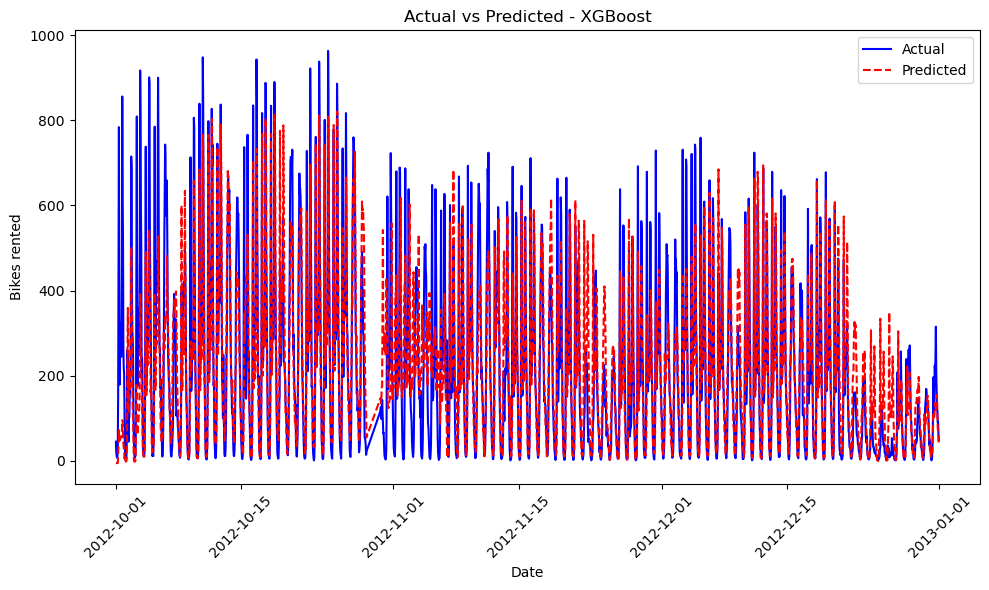

In [14]:
train = df.loc[df.index < '10-1-2012']
test = df.loc[df.index >= '10-1-2012']

xgb_train = create_features(train)
xgb_test = create_features(test)

X_train_xgb = xgb_train[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_train_xgb = xgb_train['cnt']

X_test_xgb = xgb_test[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_test_xgb = xgb_test['cnt']

import xgboost as xgb

dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

y_pred_xgb = reg.predict(dtest)



if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


plt.figure(figsize=(10, 6))
plt.plot(y_test_xgb.index, y_test_xgb, label='Actual', color='blue')
plt.plot(y_test_xgb.index, y_pred_xgb, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - XGBoost')
plt.xlabel('Date')
plt.ylabel('Bikes rented')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[0]	train-rmse:168.27112	eval-rmse:155.32836


/Users/marek/miniconda3/envs/python-for-data-analysis/lib/python3.13/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:56.33952	eval-rmse:86.86228
[156]	train-rmse:50.13869	eval-rmse:86.59967


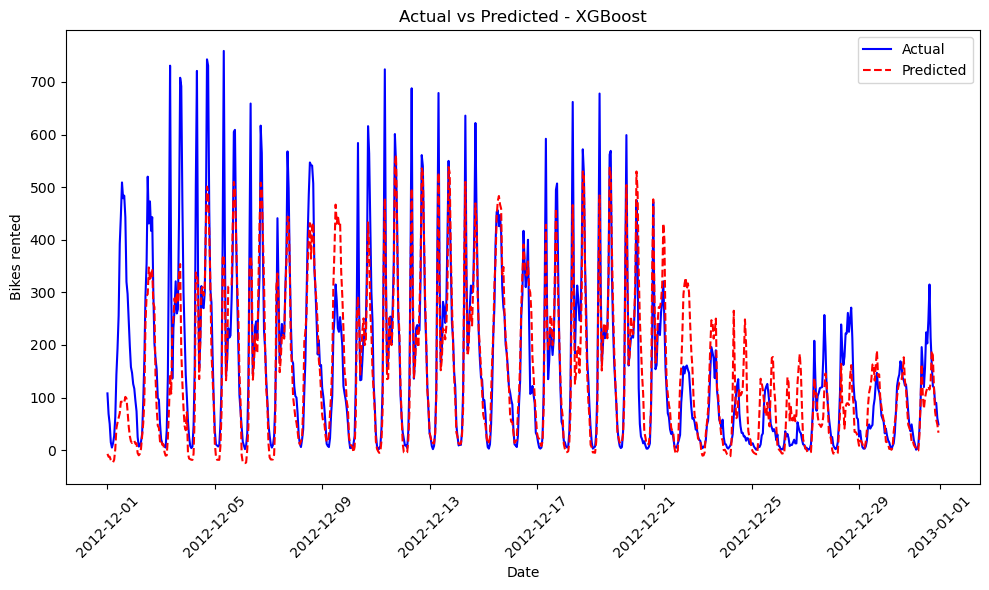

In [15]:
train = df.loc[df.index < '12-1-2012']
test = df.loc[df.index >= '12-1-2012']

xgb_train = create_features(train)
xgb_test = create_features(test)

X_train_xgb = xgb_train[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_train_xgb = xgb_train['cnt']

X_test_xgb = xgb_test[['season','weekday','yr','mnth','hr','lag_1d','lag_1w','lag_3m','lag_6m','lag_1y','rolling_mean_3d','rolling_mean_1m','rolling_mean_3m','rolling_mean_6m','rolling_mean_1y']]
y_test_xgb = xgb_test['cnt']

import xgboost as xgb

dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 5,  # Depth of the trees
    'learning_rate': 0.1,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

y_pred_xgb = reg.predict(dtest)



if 'prediction' not in df.columns:
    test['prediction'] = reg.predict(dtest)
    df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)


plt.figure(figsize=(10, 6))
plt.plot(y_test_xgb.index, y_test_xgb, label='Actual', color='blue')
plt.plot(y_test_xgb.index, y_pred_xgb, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - XGBoost')
plt.xlabel('Date')
plt.ylabel('Bikes rented')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
